# Accessing and processing the James Webb Space Telescope Data

The following is broken up into 3 steps.
1) The data extraction:
    JWST data is initially downloaded as a .tar file. This type of file is required to be extracted in python before that  
    actual data can be used
    
2) The image creation:
    Inside the extracted .tar are multiple .fits files that contain the JWST data. They can be either in a 2D array or a 3D 
    array. The technique to access both will be shown in the 6th Cell. The code will be able to generate and save the image, 
    allowing for further analysis.
    
3) The processing:
    We will be determining the number of galaxies in the generated image. A  detected 
   object will be indicated with a red circle around it.
   Lastly, the final cell will show the total number of detected objects 
   in the image.
    


In [1]:
# opening and extracting the information from a .tar file

import tarfile
# the tar file may need to be downloaded from CADCs website into the input directory
# if you already have a fits file ready for use in the output folder, then this step is not needed
tar = tarfile.open('input/tar_files/JWST-jw02738002002_02201_00002_nis-jw02738002002_02201_00002_nis-CALIBRATED.tar', "r:")

tar.extractall('output\extracted_tar')
tar.close()

In [ ]:
#Another option if you know exactly which file you wish to download is to go on CADC and in the metadata, find the files URI
# and plug it into the cadcget below.

from cadcdata import StorageInventoryClient
client = StorageInventoryClient()
client.cadcget('cadc:MOST/268_GSC0168801944_2014_gs.fits','268_GSC0168801944_2014_gs.fits') #this takes the chosen fits file and
                                                                                            # download it to your computer

In [ ]:
#You can also use astro querry to filter fits files similar to the CADC website.
# This will give you a list of all the different fits files that match your filter which you can then download using the URL.
from astroquery.cadc import Cadc
cadc = Cadc()
results = cadc.query_name('NGC253') # filter by target name
results = results[results['collection']=='JWST']# filter by archive 
results = results[results['dataRelease'] > '2022-10-29T00:00:00.000'] # filter by release date
Download_urls = cadc.get_data_urls(results)


In [ ]:
#lastly, you can also automate the downloading process by following steps below.
numberOfFiles = 5
for urls in np.arange(0,numberOfFiles,1):
    r = requests.get(w[urls])
    open('test_fits/file_'+str(urls)+'.fits','wb').write(r.content)

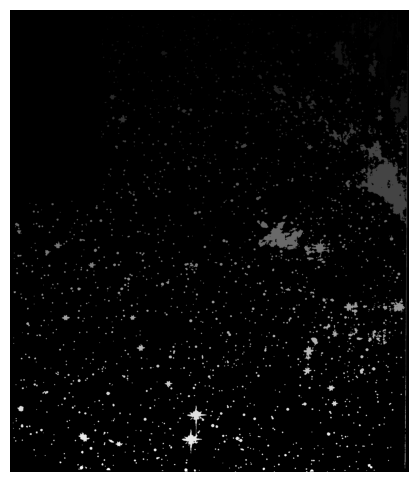

In [4]:
# Below shows the steps to accessing a certain fits files and opening it
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)


from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

#call in the file and extract in image
file_name = 'output/extracted_tar/JWST/product/jw01521-o001_t001_miri_f770w_segm.fits'  #specify your path and fits file here
image_file = get_pkg_data_filename(file_name)
image_data = fits.getdata(image_file, ext=1)

plt.axis ('off')
# The data can be in the form of a 2D or 3D array

#plt.imshow(image_data[0,:,:],origin = 'lower' ,cmap='gray')  # 3D version
plt.imshow(image_data,cmap='gray')  # 2D version

#creating a saving the image
image_name = 'created_image.png'
fig1 = plt.gcf()
plt.imsave('output/images/'+ image_name ,image_data,cmap = 'Greys_r')

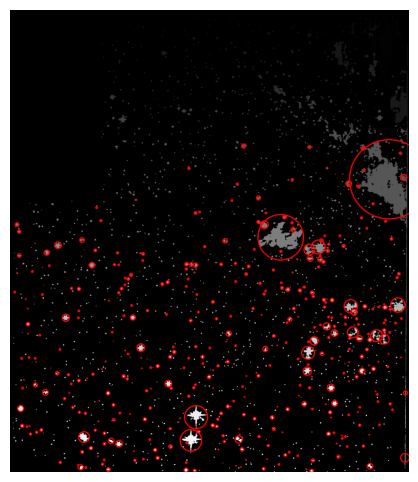

In [5]:
%matplotlib inline

#below shows a potential processing step. For this example, we will be determining the number of galaxies in an image.

from imutils import contours
from skimage import measure
import numpy as np
import imutils
import cv2
import matplotlib.pyplot as plt

print('Computing the number of galaxies...')
image = cv2.imread('output/images/created_image.png')  #add in your path and specify the image (e.g. four-stars-one-galaxy.png)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (11, 11), 0)

# threshold the image to reveal light regions in the blurred image
thresh = cv2.threshold(blurred, 100, 1000, cv2.THRESH_BINARY)[1]

# use the threshold variable to create a mask that stores only the "bright" spots using a connected component analysis
labeled = measure.label(thresh,  background=0)
bright_mask = np.zeros(thresh.shape, dtype="uint8")

# loop over the unique components
for label in np.unique(labeled):
    
	# if this is the background label, ignore it
	if label == 0:
		continue
        
    #create the label mask and determine the number of pixels in the object
	labelMask = np.zeros(thresh.shape, dtype="uint8")
	labelMask[labeled == label] = 255
	numberOFPixels = cv2.countNonZero(labelMask)
    
    # check if the number of pixels is sufficient and add to the main mask
	if numberOFPixels > 25:
		bright_mask = cv2.add(bright_mask, labelMask)
        
# Look at the contours and sort them
cnts = cv2.findContours(bright_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
cnts = imutils.grab_contours(cnts)
cnts = contours.sort_contours(cnts)[0]

counter = 0 # used to determine the total number of contours 
# loop over the contours
for (i, c) in enumerate(cnts):
    
	# draw the bright spot on the image
	(x, y, w, h) = cv2.boundingRect(c)
	((cX, cY), radius) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(cX), int(cY)), int(radius),
		(0, 255, 0), 3)
	counter = counter + 1

# show the output image
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.axis ('off')
plt.show()

In [6]:
print('The total number of detected galaxies is ' + str(counter))

The total number of detected galaxies is 378
